In [1]:
import pandas as pd
import numpy as np
from os import path as osp
import json

In [6]:
ROOT_DIR = osp.dirname(osp.dirname(osp.abspath('.')))  # 项目根目录

In [8]:
file_path = 'companies_news_info_v2.txt'

In [14]:
data_lst = []
data_path = osp.join(ROOT_DIR, 'data', 'THUCNews', file_path)

In [15]:
with open(data_path, mode='r', encoding='utf-8') as fr:
    lines = fr.readlines()
    for line in lines:
        eles = line.strip().split('\u0001')
        data_lst.append(len(eles[1]))

In [17]:
df = pd.DataFrame(data_lst)

In [19]:
df.columns = ['length']

In [20]:
df

,length
0,338
1,364
2,317
3,830
4,298
...,...
243,678
244,297
245,776
246,1801


In [21]:
df['length'].describe()

count     248.000000
mean      709.758065
std       573.299017
min       115.000000
25%       307.250000
50%       479.000000
75%       921.500000
max      3564.000000
Name: length, dtype: float64

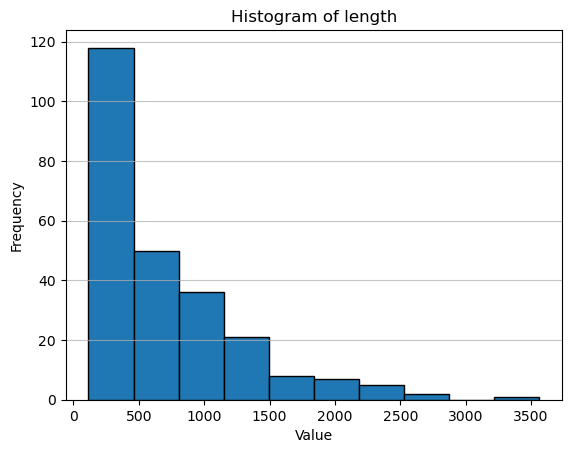

In [23]:
import matplotlib.pyplot as plt

plt.hist(df['length'], bins=10, edgecolor='black') # bins 参数控制柱子数量
plt.title('Histogram of length')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75) # 添加网格线
plt.show()

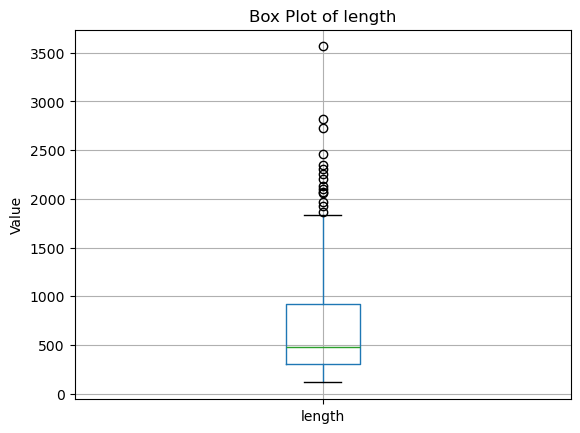

In [24]:
df.boxplot(column='length')
plt.title('Box Plot of length')
plt.ylabel('Value')
plt.show()

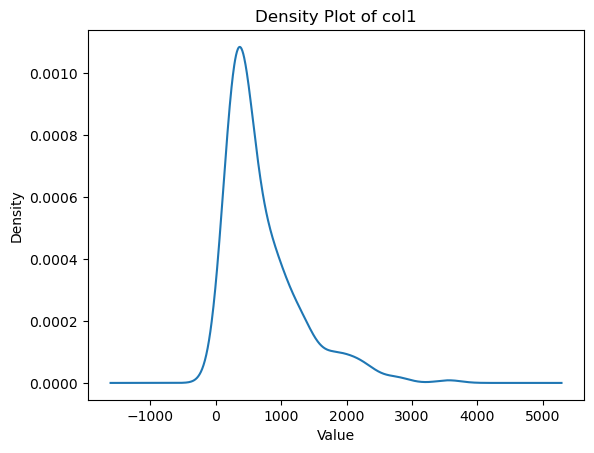

In [25]:
df['length'].plot(kind='kde')
plt.title('Density Plot of col1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [26]:
import seaborn as sns

Peak Density X-value (Approximate Mode) for 'length': 374.55


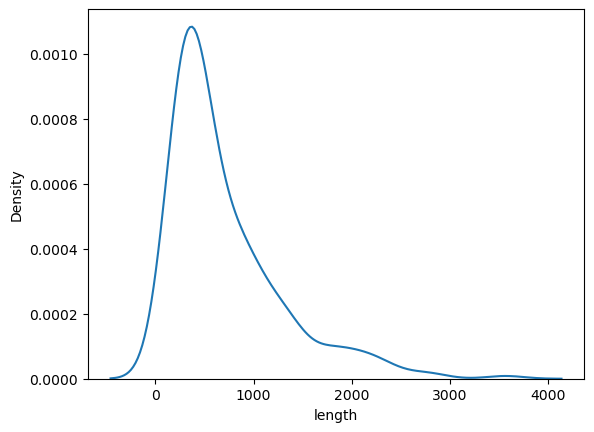

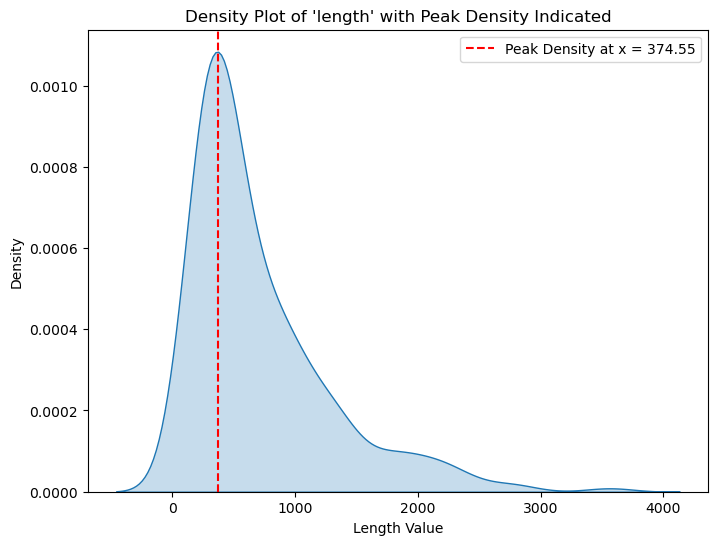

In [27]:
# Generate KDE data for 'length' column
kde = sns.kdeplot(data=df['length'],
                  clip_on=False).lines[0]
kde_x, kde_y = kde.get_data()

# Find the index of the maximum density value
max_density_index = np.argmax(kde_y)

# Get the x-value at the peak density
peak_x_value = kde_x[max_density_index]

print(f"Peak Density X-value (Approximate Mode) for 'length': {peak_x_value:.2f}")

# (Optional) Visualize the peak on the density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df['length'], fill=True)
plt.axvline(peak_x_value, color='red', linestyle='--', label=f'Peak Density at x = {peak_x_value:.2f}')
plt.legend()
plt.title("Density Plot of 'length' with Peak Density Indicated")
plt.xlabel('Length Value')
plt.ylabel('Density')
plt.show()

In [28]:
percentile_25 = df['length'].quantile(0.25)
percentile_75 = df['length'].quantile(0.75)
iqr_range = (percentile_25, percentile_75)

print(f"25th Percentile of 'length': {percentile_25:.2f}")
print(f"75th Percentile of 'length': {percentile_75:.2f}")
print(f"Interquartile Range (IQR) for 'length': {iqr_range}")

# Example for 10th to 90th percentile range
percentile_10 = df['length'].quantile(0.10)
percentile_90 = df['length'].quantile(0.90)
p90_range = (percentile_10, percentile_90)
print(f"10th Percentile of 'length': {percentile_10:.2f}")
print(f"90th Percentile of 'length': {percentile_90:.2f}")
print(f"10th-90th Percentile Range for 'length': {p90_range}")

25th Percentile of 'length': 307.25
75th Percentile of 'length': 921.50
Interquartile Range (IQR) for 'length': (307.25, 921.5)
10th Percentile of 'length': 233.70
90th Percentile of 'length': 1412.00
10th-90th Percentile Range for 'length': (233.7, 1412.0)
